In [9]:
import pandas as pd
import numpy as np
from packages.train_data_no_minmax import train_data
from packages.thesis_model_nominmax import build_model
from packages.thesis_model_nominmax import autocorrelation
from sklearn.model_selection import PredefinedSplit
import statsmodels
from statsmodels.tsa.stattools import acf
from numpy.fft import fft, ifft

from warnings import filters
import numpy as np
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import log_loss, mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from tensorflow import keras
from numpy.fft import fft, ifft
import math
import datetime as dt
from sklearn.model_selection import PredefinedSplit
import statsmodels
from statsmodels.tsa.stattools import acf
from sklearn import preprocessing
from dateutil.relativedelta import relativedelta

# My packages
from packages.train_data_no_minmax import train_data

import pandas as pd
import numpy as np
import datetime as dt

# My packages
from packages.thesis_sequence_algorithm_nominmax import thesis_sequence_algorithm
from packages.thesis_model_nominmax import evaluate_model

# Visualization
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import relativedelta

In [10]:
dataset_min = pd.read_csv('dataset_final_min.csv', infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset_h = pd.read_csv('dataset_final.csv', infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

In [12]:
dataset_h.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempC,humidity,windspeedKmph,weekday,time
datetime,,,,,,,,,
2008-07-31 23:00:00,1.893067,0.0,0.588,0.155,20,90,13,0,0
2008-08-01 00:00:00,0.460333,0.0,0.072,0.113,19,90,14,0,1
2008-08-01 01:00:00,0.405967,0.0,0.043,0.115,18,89,15,0,2
2008-08-01 02:00:00,0.390733,0.0,0.030,0.118,17,89,15,0,3
2008-08-01 03:00:00,0.361433,0.0,0.023,0.116,17,87,14,0,4


# Thesis Model

- Prepare warm up period (Define quantity)
- Train the ConvLSTM Model by warm-up period initially
- Prepare previous hourly step (Define Quantity)
- Select optimal correlated leg load by the Power Spectrum
- If Correlated leg > Theta
    - Update and reshape the input vector for ConvLSTM model
    - Implement single step ahead forecast
    - Retrain the ConvLSTM model by the observed hourly load of previous predicted time step
- Else 
    - Implement persistence model
    - Retrain the ConvLSTM model by the observed hourly load of previous predicted time step 


# Last Results
- mostrar theta para min e h com gráfico
- mostrar posições de cada theta
- mostrar thershold e quais estão sendo utilizados, qtde conv vs persistence e quais são as posições
- mostrar resultados para theta e para quantidade de features com gráficos
- mostrar resultado para cada mês e comparar os 2 modelos + persistence model para cada mês 

# Power Spectrum Algorithm

In [13]:
def get_highest_power_spectrum(teste, n_input):
    #get hourly load sequence and invert sequence since the last position is the first day in the time series
    sequence = teste[:,0][::-1]
    # get power spectrum: y(t) -> FFT -> 1/N(log|.|^2) -> IFFT -> cy(k)
    # FFT
    df_fft = fft(sequence)     
    # 1/N(log|.|^2)
    df_log = (1/(len(sequence)))*(np.log10(df_fft**2))
    # IFFT -> cy(k)
    power_spectrum = abs(ifft(df_log))[1:][::-1]
    # Standarize powerspectrum and invert sequence to come back to (y-n to y) and remove first autocorrelation.
    power_spectrum_std = ((power_spectrum - np.mean(power_spectrum))/np.std(power_spectrum) + 0.5)
    # get indexes from highest power_spectrum
    best_index_power_spectrum = np.sort(np.argpartition(power_spectrum_std, -n_input)[-n_input:])
    # min power spectrum value without first autocorrolation
    min_power_spectrum = power_spectrum_std[best_index_power_spectrum].min()
    return min_power_spectrum, best_index_power_spectrum

### Dataset with hourly steps and one week of previous data (168 hours)<br>
- - First I analyzed the value of theta considering the last one week of data and just one input (The max theta value from 168 lags), in the hourly step is used all dataset, from 2008-08-01 to 2010-08-01.

In [14]:
theta_list = []
index_list = []
date_list = []
for i in range((168),len(dataset_h)):
    dataset_autocorrelation = autocorrelation(np.array(dataset_h)[(i-(168)):i])
    min_power_spectrum, best_index_power_spectrum = dataset_autocorrelation.get_highest_power_spectrum(1)
    theta_list.append(min_power_spectrum)
    index_list.append(best_index_power_spectrum)
    date_list.append(dataset_h.iloc[[i]].index[0])
index_count_h = pd.DataFrame(index_list).value_counts()
index_theta_h = pd.concat([pd.DataFrame(index_list, columns = ['index']),pd.DataFrame(theta_list, columns = ['theta']),pd.DataFrame(date_list, columns = ['date'])], axis = 1)

In [15]:
index_theta_h[3.1] = (index_theta_h['theta'] > 3.1).astype(int)
index_theta_h[3.2] = (index_theta_h['theta'] > 3.2).astype(int)
index_theta_h[3.3] = (index_theta_h['theta'] > 3.3).astype(int)
index_theta_h[3.4] = (index_theta_h['theta'] > 3.4).astype(int)
index_theta_h[3.5] = (index_theta_h['theta'] > 3.5).astype(int)
index_theta_h[3.6] = (index_theta_h['theta'] > 3.6).astype(int)
index_theta_h[3.7] = (index_theta_h['theta'] > 3.7).astype(int)
index_theta_h[3.8] = (index_theta_h['theta'] > 3.8).astype(int)
index_theta_h[3.9] = (index_theta_h['theta'] > 3.9).astype(int)
index_theta_h[4] = (index_theta_h['theta'] > 4).astype(int)
index_theta_h[4.1] = (index_theta_h['theta'] > 4.1).astype(int)
index_theta_h[4.2] = (index_theta_h['theta'] > 4.2).astype(int)

- Plot max theta values for each minute step for the month considering one input only

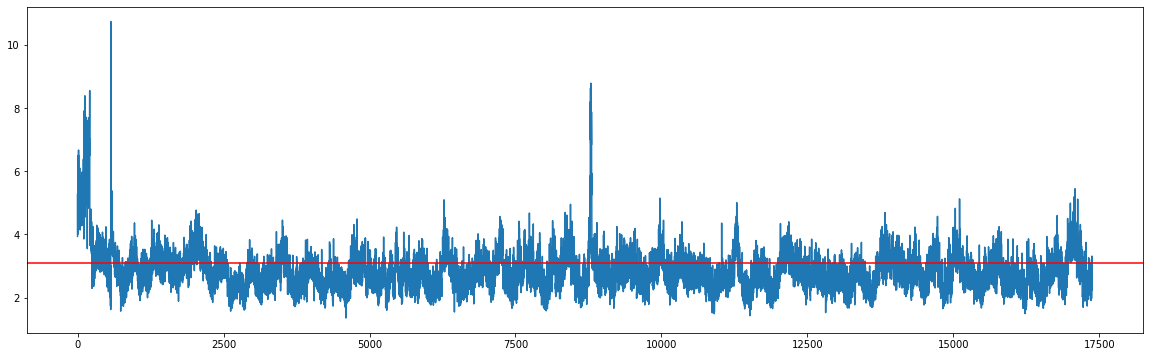

In [16]:
plt.figure(figsize=(20, 6))
plt.plot(index_theta_h['theta'])
plt.axhline(y=3.1, color = 'r')

- Analyze the count of lags index with highest value of theta

In [17]:
index_count_h.head(5)

166    8277
0      7861
165      54
1        51
11       50
dtype: int64

- Analyze the count of index lags in which theta is bigger than threshold

In [19]:
index_theta_h[index_theta_h['theta'] > 3.1].groupby('index').count().sort_values('theta', ascending = False).head(5)['theta']

index
166    1965
0      1859
11       33
164      20
155      18
Name: theta, dtype: int64

- % of lag that are going to be used by the convLSTM to precict next step

In [21]:
round(len(index_theta_h[index_theta_h['theta'] > 3.1])/len(index_theta_h)*100,2)

23.27

- % of lag that are going to be used by the convLSTM to each theta and each month

In [362]:
theta_thrshold = index_theta_h.set_index('date').resample('M').mean().round(2).iloc[:,2:]
theta_thrshold

,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4,4.1,4.2
date,,,,,,,,,,,,
2008-08-31,0.74,0.69,0.64,0.60,0.55,0.52,0.49,0.45,0.43,0.41,0.39,0.38
2008-09-30,0.26,0.20,0.16,0.12,0.08,0.06,0.05,0.03,0.02,0.02,0.01,0.01
2008-10-31,0.45,0.38,0.29,0.21,0.15,0.11,0.08,0.06,0.04,0.03,0.02,0.01
2008-11-30,0.25,0.21,0.17,0.14,0.11,0.08,0.06,0.04,0.03,0.02,0.02,0.01
2008-12-31,0.13,0.10,0.08,0.05,0.03,0.02,0.01,0.00,0.00,0.00,0.00,0.00
2009-01-31,0.17,0.12,0.09,0.06,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.00
2009-02-28,0.16,0.11,0.07,0.05,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.01
2009-03-31,0.14,0.11,0.07,0.05,0.04,0.02,0.02,0.01,0.01,0.00,0.00,0.00
2009-04-30,0.22,0.18,0.15,0.12,0.08,0.07,0.05,0.04,0.03,0.02,0.02,0.01


In [363]:
theta_thrshold.sum()

3.1    5.76
3.2    4.65
3.3    3.75
3.4    2.95
3.5    2.36
3.6    1.88
3.7    1.51
3.8    1.20
3.9    0.97
4      0.81
4.1    0.69
4.2    0.59
dtype: float64

# Results for hourly step 

In [22]:
results = pd.read_csv('params_test.csv')

In [23]:
# Transform dates in datetime
results['start_date'] = pd.to_datetime(results['start_date'])

In [24]:
# Create pivot table
analysis = pd.DataFrame(results.groupby(['start_date','theta_threshold']).min()['score']).pivot_table(values = 'score',index='start_date',columns = 'theta_threshold')
analysis.rename(columns = {1000.0 : 'ConvLSTM', 40000.0 : 'Persistence'}, inplace = True)

In [25]:
analysis_color = analysis.style.highlight_min(color = 'red', axis = 1)
analysis_color

theta_threshold,3.100000,3.200000,3.300000,3.400000,3.500000,3.600000,3.800000,3.900000,4.000000,4.100000,4.200000,ConvLSTM,Persistence
start_date,,,,,,,,,,,,,
2008-01-09 00:00:00,0.788722,0.650742,0.652015,0.655834,0.654514,0.690931,0.657839,0.658895,0.660283,0.660040,0.659416,0.796037,0.659419
2008-01-10 00:00:00,0.705667,0.691791,0.674347,0.665448,0.731755,0.656322,0.641449,0.637416,0.634882,0.633994,0.634183,0.830756,0.630331
2008-01-11 00:00:00,0.553966,0.543343,0.535426,0.531307,0.532676,0.532973,0.533064,0.533064,0.533064,0.533064,0.533064,0.717758,0.533064
2008-01-12 00:00:00,0.588295,0.593072,0.578325,0.581705,0.574441,0.562108,0.563876,0.564317,0.564225,0.562571,0.562571,0.737639,0.562571
2009-01-01 00:00:00,0.550675,0.558535,0.559551,0.558549,0.556103,0.557221,0.553621,0.553424,0.553424,0.553424,0.553424,0.749134,0.553424
2009-01-02 00:00:00,0.628048,0.624668,0.625793,0.591980,0.591204,0.589905,0.583002,0.584056,0.594434,0.604877,0.588890,0.795681,0.587751
2009-01-03 00:00:00,0.727391,0.604051,0.602985,0.600359,0.637009,0.597768,0.597303,0.597334,0.597306,0.598426,0.598332,0.717442,0.598221
2009-01-04 00:00:00,0.594123,0.593248,0.757943,0.726988,0.681932,0.673184,0.591150,0.588678,0.586697,0.615644,0.590135,0.707867,0.590670
2009-01-05 00:00:00,0.700682,0.602309,0.605573,0.604892,0.603886,0.600860,0.601901,0.601101,0.601103,0.601095,0.601095,0.730003,0.601095


# Time expenses in seconds

In [39]:
analysis_time = pd.DataFrame(results.groupby(['start_date','theta_threshold']).min()['time_run']).pivot_table(values = 'time_run',index='start_date',columns = 'theta_threshold')
analysis_time.rename(columns = {1000.0 : 'ConvLSTM', 40000.0 : 'Persistence'}, inplace = True)
analysis_time.loc[:,[3.1,'ConvLSTM']]


theta_threshold,3.1,ConvLSTM
start_date,,
2008-01-09,32.910528,41.302102
2008-01-10,42.075534,46.773740
2008-01-11,33.533083,44.405838
2008-01-12,35.051709,48.104060
2009-01-01,33.005762,47.552354
2009-01-02,34.264191,41.218241
2009-01-03,34.425339,47.614518
2009-01-04,37.086757,45.898474
2009-01-05,35.090287,47.722076


# Plot Example

In [26]:
dataset_h = dataset_h.loc[:,['Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3','tempC','weekday','time']]
df = dataset_h[(dataset_h.index >= '2008-08-01') & (dataset_h.index < '2010-08-01')]
df.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempC,weekday,time
datetime,,,,,,,
2008-08-01 00:00:00,0.460333,0.0,0.072,0.113,19,0,1
2008-08-01 01:00:00,0.405967,0.0,0.043,0.115,18,0,2
2008-08-01 02:00:00,0.390733,0.0,0.030,0.118,17,0,3
2008-08-01 03:00:00,0.361433,0.0,0.023,0.116,17,0,4
2008-08-01 04:00:00,0.401200,0.0,0.043,0.112,16,0,5


In [27]:
dataset_filtered = df[(df.index >= '2009-06-01') & (df.index < '2009-07-01')]
autocorrelation_type = 'power_spectrum'
warm_up_time = 168
theta_threshold = 3.1
leg_days_time = 168
n_steps = 1
n_length = 1
n_input = n_steps * n_length
n_features = df.shape[1]
n_out = 1
epochs = 20
epochs_retrain = 1
batch_size = 1
filters = 36
activation = 'relu'
loss = 'mse'
optimizer = 'adam'
karnel = (1,2)
dense_1 = 4
dense_2 = 1
model_parameters_PSConvLSTM = thesis_sequence_algorithm(dataset_filtered, 
                                                        autocorrelation_type, 
                                                        warm_up_time, 
                                                        theta_threshold, 
                                                        leg_days_time, 
                                                        n_steps, 
                                                        n_length, 
                                                        n_input, 
                                                        n_features, 
                                                        n_out, 
                                                        epochs, 
                                                        batch_size, 
                                                        filters, 
                                                        activation, 
                                                        loss, 
                                                        optimizer,
                                                        karnel,
                                                        epochs_retrain,
                                                        dense_1,
                                                        dense_2)
#RUN ALGO
start_time = time.time()
predict_list_PSConvLSTM, observed_list_PSConvLSTM = model_parameters_PSConvLSTM.master_algorithm()
scores_PSConvLSTM = evaluate_model(predict_list_PSConvLSTM, observed_list_PSConvLSTM)
score_PSConvLSTM, scores_PSConvLSTM = scores_PSConvLSTM.evaluate_model()
time_run = (time.time() - start_time)

4.326219320297241
23.03850793838501


In [28]:
score_PSConvLSTM

0.6274007241783525

c:\Users\agottanil\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


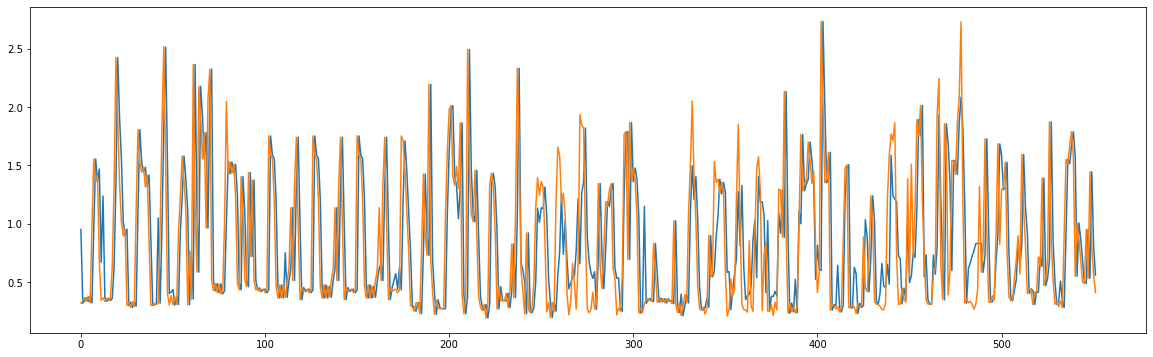

In [29]:
plt.figure(figsize=(20, 6))
plt.plot(predict_list_PSConvLSTM)
plt.plot(observed_list_PSConvLSTM)